In [6]:
%load_ext autoreload
%autoreload 2
from __future__ import absolute_import
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib
import sklearn
from sklearn_pandas import DataFrameMapper
import esn_cell
matplotlib.style.use('ggplot')
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
df = pd.read_csv('india_surroundings_1mar2016 _28_feb_2017.csv')
del df['IRIS ID'], df['Year'], df['Month'], df['Day'], df['Time UTC'], df['Region']
df = df.iloc[::-1]
#df = pd.get_dummies(df)

In [8]:
train_test_ratio = .7
train_size = int(df.shape[0] * train_test_ratio)
train_data = df.iloc[:train_size]
test_data = df.iloc[train_size:]

In [9]:
mapper = DataFrameMapper([
       # (['Region'], None),
        (['Mag'],sklearn.preprocessing.StandardScaler()),
        (['Lat'],sklearn.preprocessing.StandardScaler()),
        (['Lon'],sklearn.preprocessing.StandardScaler()),
        (['Depth km'],sklearn.preprocessing.StandardScaler()),
        (['Timestamp'], sklearn.preprocessing.StandardScaler()) 
    ],default = None)
train_data = mapper.fit_transform(train_data)
#train_data[['Mag','Lat','Lon','Timestamp','Depth km']] = train_data[['Mag','Lat','Lon','Timestamp','Depth km']].astype(float)
test_data = mapper.transform(test_data)
#test_data[['Mag','Lat','Lon','Timestamp','Depth km']] = test_data[['Mag','Lat','Lon','Timestamp','Depth km']].astype(float)


/home/nikhil/.conda/envs/sarcoma/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


In [11]:
train_data.shape


(196, 5)

In [0]:
tr_size=500
washout_size=15
units=30
connectivity=0.2
scale=0.7
num_features = 5

graph = tf.Graph()
with graph.as_default():
    data_t = tf.reshape(tf.constant(data), [1, , num_features])
    esn = ESNCell(units, connectivity, scale)

    print("Building graph...")
    outputs, final_state = tf.nn.dynamic_rnn(esn, data_t, dtype=tf.float32)
    washed = tf.squeeze(tf.slice(outputs, [0, washout_size, 0], [-1, -1, -1]))

with tf.Session(graph=graph) as sess:
    tf.global_variables_initializer().run()

    print("Computing embeddings...")
    res = sess.run(washed)

    print("Computing direct solution...")
    state = np.array(res)
    tr_state = np.mat(state[:tr_size])
    ts_state = np.mat(state[tr_size:])
    wout = np.transpose(np.mat(data[washout_size+1:tr_size+washout_size+1]) * np.transpose(np.linalg.pinv(tr_state)))

    print("Testing performance...")
    ts_out = np.mat((np.transpose(ts_state * wout).tolist())[0][:-1])
    ts_y = np.mat(data[washout_size+tr_size+1:])

    ts_mse = np.mean(np.square(ts_y - ts_out))

    print("Test MSE: " + str(ts_mse))


/home/nikhil/.conda/envs/sarcoma/lib/python3.5/site-packages/sklearn/metrics/regression.py:482: DeprecationWarning: Default 'multioutput' behavior now corresponds to 'variance_weighted' value which is deprecated since 0.17, it will be changed to 'uniform_average' starting from 0.19.
  DeprecationWarning)


total r2 score 0.558496044395
r2 scores for individual variables {'Timestamp': 0.66200000000000003, 'Depth km': 0.34399999999999997, 'Mag': 0.64400000000000002, 'Lat': 0.44700000000000001, 'Lon': 0.60399999999999998}


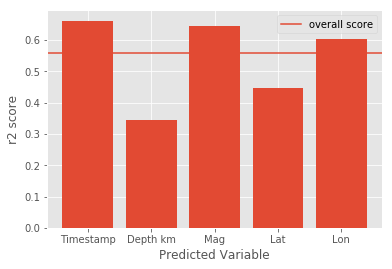

In [38]:
test_targets, test_outputs = np.reshape(test_targets,(-1,5)), np.reshape(test_outputs,(-1,5)) 
from sklearn.metrics import r2_score
total_error = r2_score(test_targets, test_outputs) 
print("total r2 score", total_error)
plt.axhline([total_error],0,1,label='overall score')
indv_error_dict = {col:np.round(r2_score(test_targets[:,i], test_outputs[:,i]),3) for i, col in enumerate(df.columns)}
print("r2 scores for individual variables", indv_error_dict)
plt.bar(range(len(indv_error_dict)), indv_error_dict.values())
plt.xticks(range(len(indv_error_dict)), indv_error_dict.keys())
plt.ylabel('r2 score')
plt.xlabel('Predicted Variable')
plt.legend()
plt.savefig("test.eps", format="eps")
plt.show()